In [1]:
import numpy as np
from h5flow.data import dereference
import h5flow
import matplotlib.pyplot as plt
import glob
import mplhep as hep

flist = glob.glob('/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/*.hdf5')
f_manager1 = h5flow.data.H5FlowDataManager(flist, 'r')

#Detector boundaries
x_boundaries = np.array([-63.931, -3.069, 3.069, 63.931])
y_boundaries = np.array([-42-19.8543, -42+103.8543]) 
z_boundaries = np.array([-64.3163,  -2.6837, 2.6837, 64.3163])


def back_track_hits(files, hits_dset_name):
    makeup_of_selection = []
    energy_ratio = []
    for file in files:
        print(file)
        try:
            # Load data sets
            f = h5flow.data.H5FlowDataManager(file, 'r')

            segments = f['mc_truth/segments/data']
            trajectories = f['mc_truth/trajectories/data']
            dset_hits = f['charge/'+hits_dset_name+'/data']

            track2hits = dereference(
                f['/analysis/rock_muon_tracks/data']['rock_muon_id'],     # indices of A to load references for, shape: (n,)
                f['/analysis/rock_muon_tracks/ref/charge/calib_prompt_hits/ref'],  # references to use, shape: (L,)
                f['/charge/calib_prompt_hits/data'],
                ref_direction=(0,1)  # dataset to load, shape: (M,)
            )

            # Loop through the tracks
            for hits_of_track in track2hits:
                track_makeup = {}

                trajs_of_track = []

                hits = np.array([tup for tup in hits_of_track.data if not all(np.all(elem == 0) for elem in tup)], dtype=hits_of_track.dtype)

                total_charge = np.sum(hits['Q'])
                total_energy = np.sum(hits['E'])

                hit_ref = hits['id']
                hits_bt = f['mc_truth/'+hits_dset_name[:-1]+'_backtrack/data'][hit_ref] 

                # Check if hit['id'] matches index in dset_hits_name
                indices = np.where(np.isin(dset_hits['id'], hits['id']))[0]

                for i in range(len(indices)):
                    if indices[i] != hits['id'][i]:
                        print(f'WARNING: rock_muon hit id not the same as {hits_dset_name} index')

                # Plot all of the backtracked segment positions
                for hit in hits_bt:
                    for cont in range(len(hit['fraction'])):
                        if hit['fraction'][cont] > 0.0001:
                            seg_id = hit['segment_ids'][cont]
                            seg = segments[seg_id]
                            
                            # Append trajectory information to the list
                            trajs_of_track.append([
                                seg['file_traj_id'],  # File trajectory ID
                                seg['n_electrons'],  # Number of electrons
                                hit['fraction'][cont],  # Fraction associated with the hit
                                seg_id
                            ])

                            if not seg['segment_id'] == seg_id:
                                print(f'WARNING: segment id not the same as segment index!')

                traj_arr = np.array(trajs_of_track)
                unique_trajs = np.unique(traj_arr[:, 0])

                for traj in unique_trajs:
                    #Get makeup of track
                    index= np.where(np.isin(trajectories['file_traj_id'],traj))[0]
                    
                    mask = traj_arr[:,0] == traj
                    
                    wanted_segments = segments[np.unique(np.array(traj_arr[mask][:,-1], dtype = int))]
                    pdg_of_traj = trajectories[index]['pdg_id'][0]
                    E_of_traj = sum(wanted_segments['dE'])
                    #E_of_traj = abs(trajectories[index]['E_end'] - trajectories[index]['E_start'])[0]
                    
                    if pdg_of_traj not in track_makeup.keys():
                        track_makeup[f"{pdg_of_traj}"] = E_of_traj
                    else:
                        track_makeup[f"{pdg_of_traj}"] = track_makeup[f"{pdg_of_traj}"] + E_of_traj
                    
                    
                
                total_E_of_track = sum(track_makeup.values())

                for key in track_makeup.keys():
                    track_makeup[f'{key}'] = round(track_makeup[f'{key}']/total_E_of_track,6)
                
                recon_true_E_ratio = total_energy/total_E_of_track
                makeup_of_selection.append(track_makeup)
                
                energy_ratio.append(recon_true_E_ratio)
        except Exception as e:
            print(f'Error processing file {file}: {e}')
            
        
    return makeup_of_selection, np.array(energy_ratio)
 

data_set = 'calib_prompt_hits'
# demonstration of generic backtracking
makeup, energy_ratio = back_track_hits(f_manager1.filepath[:1], data_set)

/global/cfs/cdirs/dune/users/demaross/MiniRun5_files_new_cluster/MiniRun5_1E19_RHC.flow.0000234.FLOW.hdf5


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fc0ebd27df0>, errorbar=None, legend_artist=None)]

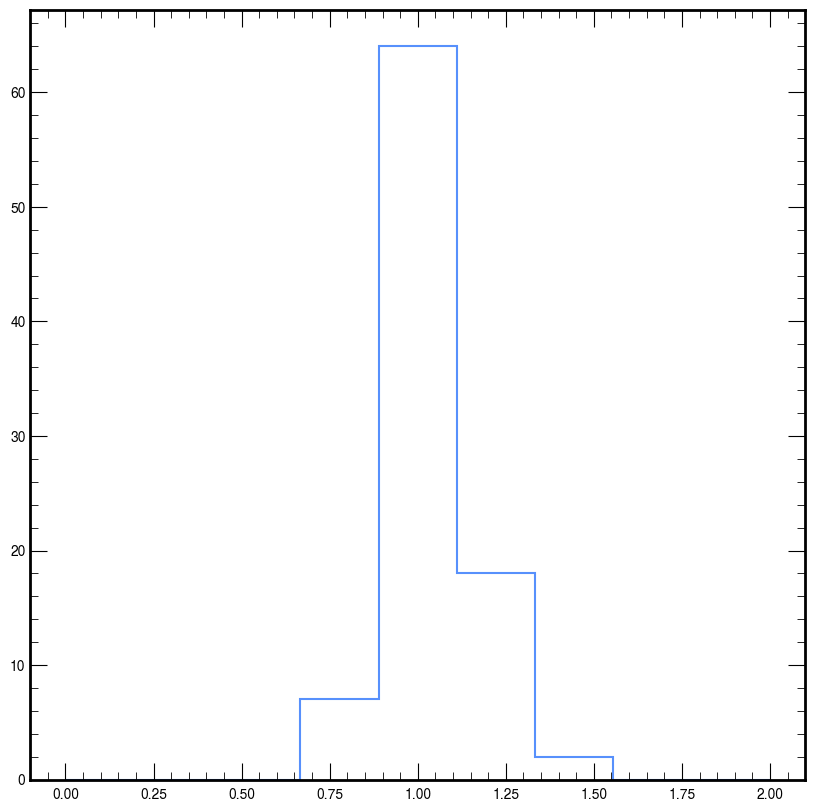

In [4]:
plt.style.use(hep.style.CMS)

plt.rcParams.update({'font.size': 12})

h, bins = np.histogram(energy_ratio, bins = np.linspace(0,2,10))

hep.histplot(h, bins)

In [3]:
print(makeup)

[{'13': 0.999716, '11': 0.000271, '22': 1.3e-05}, {'13': 0.998839, '11': 0.001148, '22': 1.3e-05}, {'-13': 0.998287, '11': 0.0017, '22': 1.3e-05}, {'-13': 0.959118, '11': 0.000266, '22': 1.3e-05, '-11': 0.040603}, {'-13': 0.995417, '11': 0.004569, '22': 1.5e-05}, {'-13': 0.999935, '11': 5.2e-05, '22': 1.3e-05}, {'13': 0.924541, '11': 0.000464, '22': 1.2e-05, '-11': 0.074983}, {'-13': 0.999963, '11': 2.3e-05, '22': 1.3e-05}, {'-13': 0.973162, '11': 0.000318, '22': 1.4e-05, '-11': 0.026506}, {'-13': 0.999879, '11': 0.000108, '22': 1.3e-05}, {'-13': 0.999936, '11': 5.1e-05, '22': 1.3e-05}, {'-13': 0.999816, '11': 0.000168, '22': 1.6e-05}, {'-13': 0.996417, '11': 0.003569, '22': 1.3e-05}, {'-13': 0.9559, '11': 0.043959, '22': 0.000141}, {'13': 0.949284, '11': 0.001349, '22': 1.3e-05, '-13': 0.034899, '-11': 0.014455}, {'-13': 0.959646, '11': 0.00159, '-11': 0.038753, '22': 1.2e-05}, {'13': 0.9999, '11': 8.5e-05, '22': 1.5e-05}, {'-13': 0.997297, '11': 0.002688, '22': 1.6e-05}, {'-13': 0.99